In [51]:
from diffusers import AutoencoderKL, StableCascadeCombinedPipeline
from PIL import Image
from torchvision.transforms.functional import to_tensor
import torch
import numpy as np

In [46]:
class VAEWrapper:
    def __init__(self, checkpoint_dir: str = "vae", device=None):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device
        self.model = AutoencoderKL.from_pretrained(checkpoint_dir).eval().to(device)

    @torch.no_grad()
    def encode(self, image: Image.Image) -> torch.Tensor:
        # transform image to tensor
        image = (to_tensor(image) * 2.0 - 1.0)
        # create batch and move to device
        image = image.unsqueeze(0).to(self.device)
        # encode image
        output = self.model.encode(image)
        latents = output.latent_dist.sample()
        return latents.cpu().squeeze(0)

    @torch.no_grad()
    def decode(self, latents: torch.Tensor):
        # create batch and move to device
        latents = latents.unsqueeze(0).to(self.device)
        image = self.model.decode(latents).sample
        image = (image / 2.0 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
        image = Image.fromarray(image[0])
        return image


vae_wrapper = VAEWrapper("vae_instructpix2pix")


In [56]:
image1 = Image.open("/media/dbahrami/2tb-hdd/d2d_fail_cases/before_1.jpg")
image2 = Image.open("/media/dbahrami/2tb-hdd/d2d_fail_cases/after_1.jpg")
image1.thumbnail((1024, 1024), Image.Resampling.LANCZOS)
# make sure sides are divisible by 8
w, h = image1.size
if w % 8 != 0:
    w = w + 8 - w % 8
if h % 8 != 0:
    h = h + 8 - h % 8
image1 = image1.resize((w, h), Image.Resampling.LANCZOS)
image2 = image2.resize(image1.size, Image.LANCZOS)

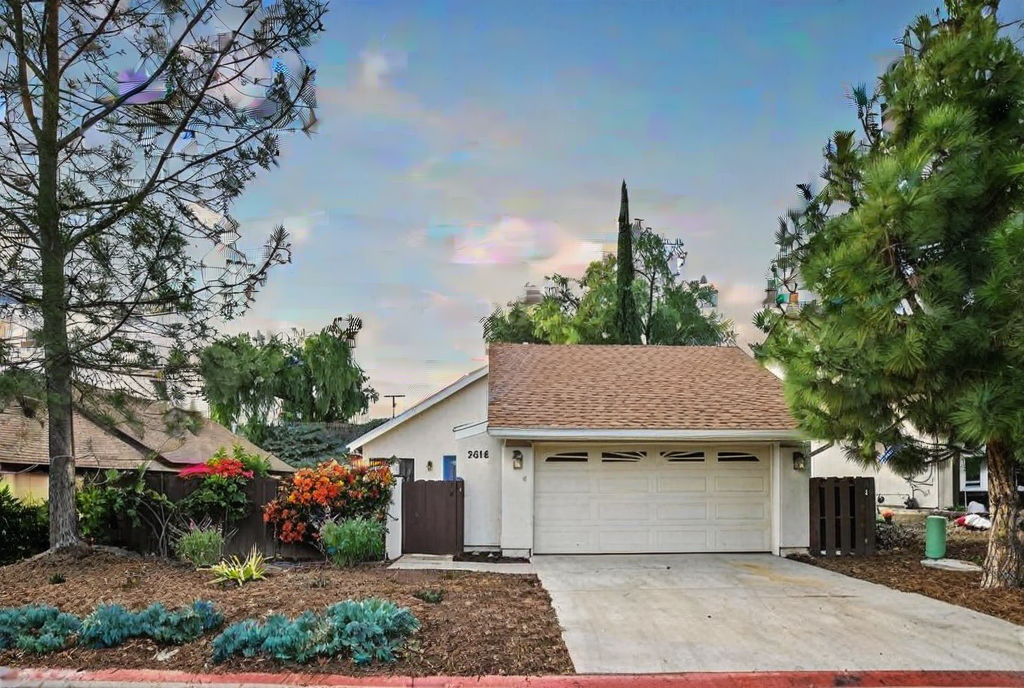

In [63]:
latents1 = vae_wrapper.encode(image1)
latents2 = vae_wrapper.encode(image2)
alpha = 0.5
latents_mid = alpha * latents1 + (1 - alpha) * latents2
# latents1 = latents1  + 0.1 * torch.randn_like(latents1)
reconstructed_image = vae_wrapper.decode(latents_mid)
reconstructed_image


In [60]:
((np.asarray(image1) - np.asarray(reconstructed_image))**2).mean()

56.54447286443193

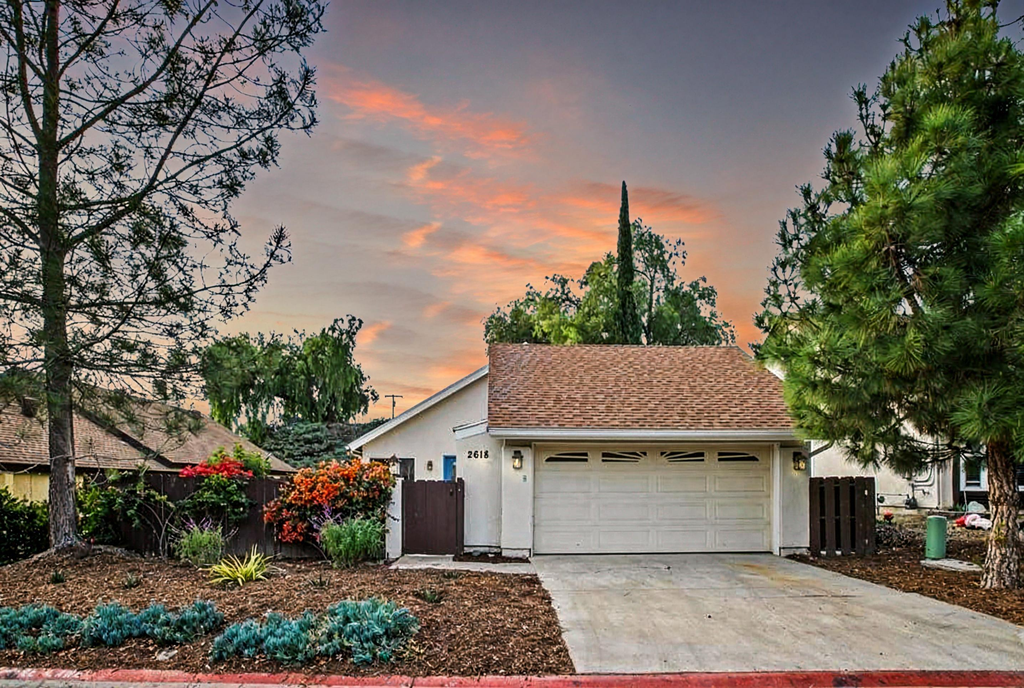

In [62]:
image2

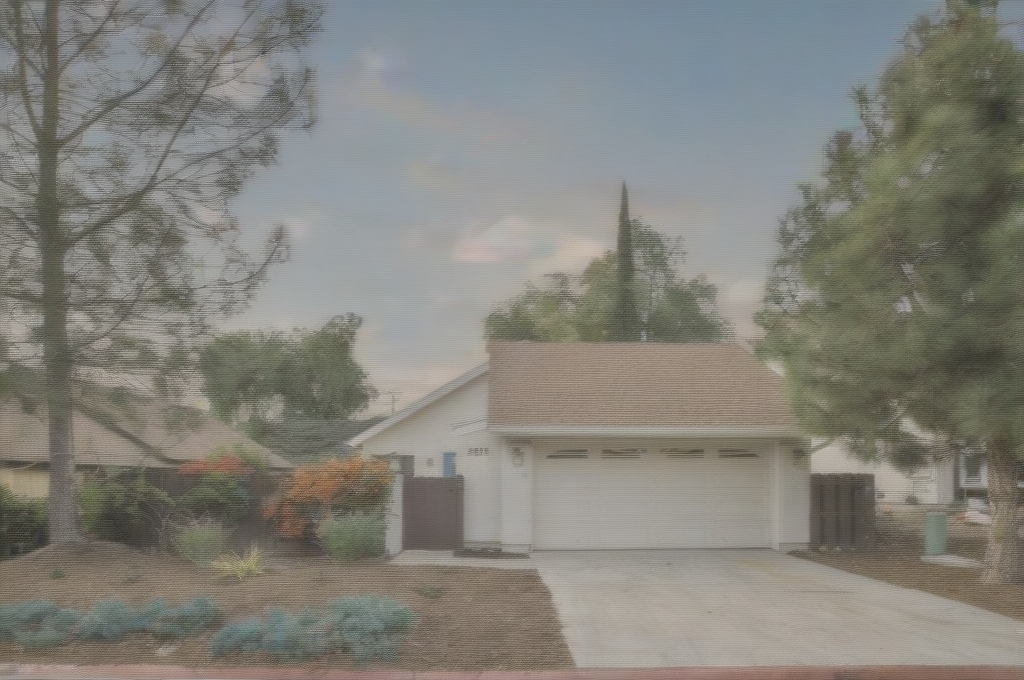

In [11]:
latents2.shape

torch.Size([4, 85, 128])

In [5]:
latents.shape

torch.Size([4, 91, 128])

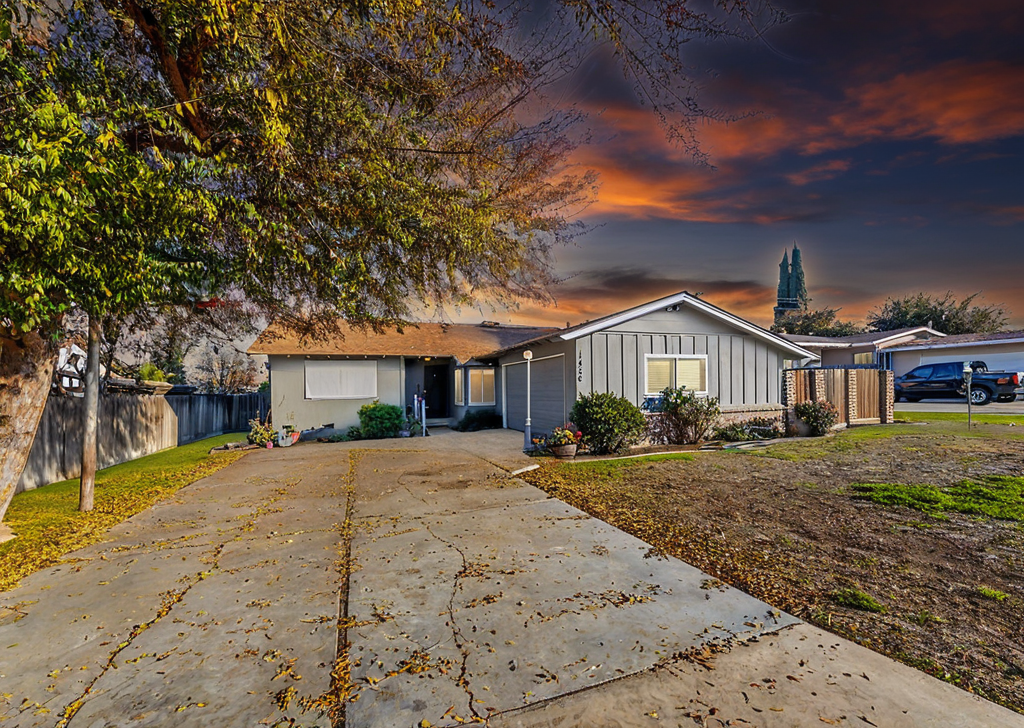

In [6]:
reconstructed_image